<a href="https://colab.research.google.com/github/brepowell/ML-Contest-Series/blob/main/MLSeriesSupervisedLearningTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Breanna Powell

CSS 539

# To run:
Use an IDE that will allow you to open a Jupyter Notebook.

For example, use Anaconda Navigator to open Visual Studio Code.

You may need to select a kernel to run the program.

I used base(Python 3.10.9)

## Import Libraries

In [118]:
import pandas as pd
import matplotlib as plt

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

## Data Information

From:
https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

More Info:
https://innovation.ukpowernetworks.co.uk/projects/low-carbon-london

"Created 9 years ago, updated 2 years ago
Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

Readings were taken at half hourly intervals. The customers in the trial were recruited as a balanced sample representative of the Greater London population.

The dataset contains energy consumption, in kWh (per half hour), unique household identifier, date and time. The CSV file is around 10GB when unzipped and contains around 167million rows.

Within the data set are two groups of customers. The first is a sub-group, of approximately 1100 customers, who were subjected to Dynamic Time of Use (dToU) energy prices throughout the 2013 calendar year period. The tariff prices were given a day ahead via the Smart Meter IHD (In Home Display) or text message to mobile phone. Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied. The dates/times and the price signal schedule is availaible as part of this dataset. All non-Time of Use customers were on a flat rate tariff of 14.228pence/kWh.

The signals given were designed to be representative of the types of signal that may be used in the future to manage both high renewable generation (supply following) operation and also test the potential to use high price signals to reduce stress on local distribution grids during periods of stress.

The remaining sample of approximately 4500 customers energy consumption readings were not subject to the dToU tariff."


## Create a huge dataframe with all hourly info

In [119]:
##############################
# This takes about 3 minutes #
##############################

import glob

def readAllHourlyData():
    # Read all CSV files and concatenate them into a single DataFrame
    path = "data/archive/halfhourly_dataset/halfhourly_dataset/" 

    allFiles = glob.glob(path + "block_*.csv")
    dfList = []
    for filename in allFiles:
        df = pd.read_csv(filename)
        dfList.append(df)
    fullDf = pd.concat(dfList)

    return fullDf

londonData = readAllHourlyData()
londonData.shape

C:\Users\brely\AppData\Local\Temp\ipykernel_2596\1060363303.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
C:\Users\brely\AppData\Local\Temp\ipykernel_2596\1060363303.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
C:\Users\brely\AppData\Local\Temp\ipykernel_2596\1060363303.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
C:\Users\brely\AppData\Local\Temp\ipykernel_2596\1060363303.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
C:\Users\brely\AppData\Local\Temp\ipykernel_2596\1060363303.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
C:\Users\brely\AppDa

(167817021, 3)

In [120]:
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 1605346
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   LCLid           object
 1   tstp            object
 2   energy(kWh/hh)  object
dtypes: object(3)
memory usage: 5.0+ GB


In [121]:
londonData.head()
path = "Data/pickles/"
londonData.to_pickle(path + "londonData01Initial.pkl")

# SELECT FEATURES

What features do I want?

* NaN's or Null values - 0 for value or 1 for NaN - NaN could be a blackout
* Day, time, etc.
* Weekends - 0 for weekday or 1 for weekend
* Holidays - 0 for regular day 1 for holiday
* Customer information - affluent, etc.
* Customers served - How many customers were represented on that day? - Might be needed for normalization
* Dip in customers - Could be a sign of an outage - 0 for no dip, 1 for dip
* Blackout signature - mark hours before 0 max energy as signature days?
* Weather Features - add later to see if improves

# ==== SAVE AND LOAD ====
I decided to save the data as a pkl here so that I could just run the cells below this point.

In [1]:
############################################
# This takes about 35 seconds to a minute  #
############################################

import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck

pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

# Load
path = "Data/pickles/"
londonData = pd.read_pickle(path + "londonData01Initial.pkl")

## Drop Days and Customers from Data Exploration

In [2]:
#daysToDrop = pd.read_pickle(path + "daysDropped.pkl")
#customersToDrop = pd.read_pickle(path + "customersDropped.pkl")

## Feature: Null / NaN

In [3]:
import numpy as np

# In this dataset, NaN is marked as Null
londonData.replace({'energy(kWh/hh)': {'NULL': np.nan}}, inplace=True)
londonData.replace({'energy(kWh/hh)': {'Null': np.nan}}, inplace=True)
londonData.replace({'energy(kWh/hh)': {'null': np.nan}}, inplace=True)
    
londonData["isNA"] = londonData["energy(kWh/hh)"].isna().astype(int)
print("Number of NaN values: \n{}".format(londonData["isNA"].value_counts(dropna=False)))
londonData.head()


Number of NaN values: 
0    167811461
1         5560
Name: isNA, dtype: int64


,LCLid,tstp,energy(kWh/hh),isNA
0,MAC000002,2012-10-12 00:30:00.0000000,0,0
1,MAC000002,2012-10-12 01:00:00.0000000,0,0
2,MAC000002,2012-10-12 01:30:00.0000000,0,0
3,MAC000002,2012-10-12 02:00:00.0000000,0,0
4,MAC000002,2012-10-12 02:30:00.0000000,0,0


In [4]:
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 1605346
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   LCLid           object
 1   tstp            object
 2   energy(kWh/hh)  object
 3   isNA            int32 
dtypes: int32(1), object(3)
memory usage: 5.6+ GB


In [5]:
# Fill NaN's with the previous value
londonData["energy(kWh/hh)"] = londonData["energy(kWh/hh)"].ffill().astype(float)

In [11]:
# Imputing the missing values worked to change the energy to a float64
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 1605346
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LCLid           object 
 1   tstp            object 
 2   energy(kWh/hh)  float64
 3   isNA            int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 5.7+ GB


In [7]:
# No more NaNs
nan_count = londonData.isnull().sum().sum()
nan_count

0

In [8]:
# Save
londonData.head()
path = "Data/pickles/"
londonData.to_pickle(path + "londonData02Null.pkl")

# ==== SAVE AND LOAD ====
I decided to save the data as a pkl here so that I could just run the cells below this point.

## Feature: Day, Month, Year, Hour, Minute

In [12]:
############################################
# This takes about 35 seconds to a minute  #
############################################

import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

# Load
path = "Data/pickles/"
londonData = pd.read_pickle(path + "londonData02Null.pkl")

In [13]:
##############################
# This takes about 2 minutes #
##############################

def extractDayInformation(data):

    # Convert 'tstp' column to datetime
    data['tstp'] = pd.to_datetime(data['tstp'])
    
    # Extract day information
    data['year'] = data['tstp'].dt.year              # 2011, 2012, 2013, 2014
    data['month'] = data['tstp'].dt.month            # 1 to 12
    data['day'] = data['tstp'].dt.day                # 1 to 31
    data['hour'] = data['tstp'].dt.hour              # 1 to 23
    data['minute'] = data['tstp'].dt.minute          # 0 to 54 - I thought this dataset only had half hour increments?
    # data['second'] = data['tstp'].dt.second          # 0 to 59 - Might not need seconds
    data['dayNumber'] = data['tstp'].dt.dayofweek    # 0 to 6 where 0 is Monday and 6 is Sunday
    data['dayString'] = data['tstp'].dt.strftime("%Y-%m-%d") # Will be used for merging other data

    # Get the unix timestamp as well - 1322038800 to 1393545600 - too much information
    # data['unixTimeStamp'] = (data['tstp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    # Get rid of the tstp column
    data = data.drop(['tstp'], axis=1)
    
    return data

londonData = extractDayInformation(londonData)
londonData.head()


,LCLid,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,dayString
0,MAC000002,0.0,0,2012,10,12,0,30,4,2012-10-12
1,MAC000002,0.0,0,2012,10,12,1,0,4,2012-10-12
2,MAC000002,0.0,0,2012,10,12,1,30,4,2012-10-12
3,MAC000002,0.0,0,2012,10,12,2,0,4,2012-10-12
4,MAC000002,0.0,0,2012,10,12,2,30,4,2012-10-12


In [14]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html
# 0 is Monday; 6 is Sunday; 5 is Saturday
londonData["weekend"] = (londonData["dayNumber"] > 4).astype(int)

In [15]:
# Save

londonData.head()
path = "Data/pickles/"
londonData.to_pickle(path + "londonData03DayInfo.pkl")

# ==== SAVE AND LOAD ====
I decided to save the data as a pkl here so that I could just run the cells below this point.

## Feature: Customers Count Per Day
I will call this CustomerCount

In [1]:
############################################
# This takes about 35 seconds to a minute  #
############################################

import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

# Load
path = "Data/pickles/"
londonData = pd.read_pickle(path + "londonData03DayInfo.pkl")

In [2]:
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 1605346
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LCLid           object 
 1   energy(kWh/hh)  float64
 2   isNA            int32  
 3   year            int64  
 4   month           int64  
 5   day             int64  
 6   hour            int64  
 7   minute          int64  
 8   dayNumber       int64  
 9   dayString       object 
 10  weekend         int32  
dtypes: float64(1), int32(2), int64(6), object(2)
memory usage: 13.8+ GB


In [3]:
allDays = pd.read_pickle(path + "allDays.pkl")

In [4]:
##############################
# This takes about 5 minutes #
##############################

import pandas as pd

# Merge the two dataframes on the "day" and "LCLid" columns
mergedData = londonData.merge(allDays, left_on='dayString', right_on='date', how='left')

In [5]:
mergedData.head()

,LCLid,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,dayString,weekend,CustomerCount
0,MAC000002,0.0,0,2012,10,12,0,30,4,2012-10-12,0,5261.0
1,MAC000002,0.0,0,2012,10,12,1,0,4,2012-10-12,0,5261.0
2,MAC000002,0.0,0,2012,10,12,1,30,4,2012-10-12,0,5261.0
3,MAC000002,0.0,0,2012,10,12,2,0,4,2012-10-12,0,5261.0
4,MAC000002,0.0,0,2012,10,12,2,30,4,2012-10-12,0,5261.0


In [6]:
mergedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 167817020
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LCLid           object 
 1   energy(kWh/hh)  float64
 2   isNA            int32  
 3   year            int64  
 4   month           int64  
 5   day             int64  
 6   hour            int64  
 7   minute          int64  
 8   dayNumber       int64  
 9   dayString       object 
 10  weekend         int32  
 11  CustomerCount   float64
dtypes: float64(2), int32(2), int64(6), object(2)
memory usage: 15.0+ GB


In [7]:
# Save
path = "Data/pickles/"
mergedData.to_pickle(path + "londonData04CustomerCount.pkl")

### Dip in customers? - Could be a sign of an outage - 0 for no dip, 1 for dip

In [8]:
import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

############################################
# This takes about 35 seconds to a minute  #
############################################

# Load
path = "Data/pickles/"
londonData = pd.read_pickle(path + "londonData04CustomerCount.pkl")
londonData.head()

,LCLid,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,dayString,weekend,CustomerCount
0,MAC000002,0.0,0,2012,10,12,0,30,4,2012-10-12,0,5261.0
1,MAC000002,0.0,0,2012,10,12,1,0,4,2012-10-12,0,5261.0
2,MAC000002,0.0,0,2012,10,12,1,30,4,2012-10-12,0,5261.0
3,MAC000002,0.0,0,2012,10,12,2,0,4,2012-10-12,0,5261.0
4,MAC000002,0.0,0,2012,10,12,2,30,4,2012-10-12,0,5261.0


In [9]:
dipDays = pd.read_csv("dipDays.csv")
dipDays = pd.DataFrame(dipDays["date"])
dipDays["dipDay"] = 1
dipDays


,date,dipDay
0,2012-04-16,1
1,2012-04-26,1
2,2012-04-29,1
3,2012-04-30,1
4,2012-05-01,1
5,2012-05-02,1
6,2012-05-07,1
7,2012-05-08,1
8,2012-05-09,1
9,2012-05-10,1


In [10]:
##############################
# This takes about 5 minutes #
##############################

mergedData2 = londonData.merge(dipDays, left_on='dayString', right_on='date', how='left')
mergedData2['dipDay'] = mergedData2['dipDay'].fillna(0).astype(int)


In [11]:
# Drop the extra columns
mergedData2.drop(columns=['date','dayString'], inplace=True)
mergedData2.head()

,LCLid,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,weekend,CustomerCount,dipDay
0,MAC000002,0.0,0,2012,10,12,0,30,4,0,5261.0,0
1,MAC000002,0.0,0,2012,10,12,1,0,4,0,5261.0,0
2,MAC000002,0.0,0,2012,10,12,1,30,4,0,5261.0,0
3,MAC000002,0.0,0,2012,10,12,2,0,4,0,5261.0,0
4,MAC000002,0.0,0,2012,10,12,2,30,4,0,5261.0,0


In [12]:
mergedData2["dipDay"].value_counts()

0    164010380
1      3806641
Name: dipDay, dtype: int64

In [13]:
# Save
path = "Data/pickles/"
mergedData2.to_pickle(path + "londonData05WithDips.pkl")

# ==== SAVE AND LOAD ====
I decided to save the data as a pkl here so that I could just run the cells below this point.

In [1]:
############################################
# This takes about 35 seconds to a minute  #
############################################

import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

# Load
import pandas as pd
path = "Data/pickles/"
londonData = pd.read_pickle(path + "londonData05WithDips.pkl")

In [2]:
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 167817020
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LCLid           object 
 1   energy(kWh/hh)  float64
 2   isNA            int32  
 3   year            int64  
 4   month           int64  
 5   day             int64  
 6   hour            int64  
 7   minute          int64  
 8   dayNumber       int64  
 9   weekend         int32  
 10  CustomerCount   float64
 11  dipDay          int32  
dtypes: float64(2), int32(3), int64(6), object(1)
memory usage: 14.4+ GB


## Customer Details

In [3]:
import pandas as pd
path = "Data/archive/"
house = pd.read_csv(path + 'informations_households.csv')
house = pd.DataFrame(house)

In [4]:
house.value_counts("Acorn_grouped")

Acorn_grouped
Affluent       2192
Adversity      1816
Comfortable    1507
ACORN-U          49
ACORN-            2
dtype: int64

In [5]:
house.value_counts("stdorToU")


stdorToU
Std    4443
ToU    1123
dtype: int64

In [6]:
columnsToDrop = ["file", "Acorn"]
house.drop(columns=columnsToDrop, inplace=True)
house.rename(columns={"stdorToU" : "ToU", "LCLid": "ID"}, inplace=True)

# Replace stdorToU with 0 for std and 1 for ToU
house["ToU"] = (house["ToU"] == "ToU").astype(int)

In [7]:
houseFeatures = pd.get_dummies(house, columns=["Acorn_grouped"], prefix="AG_")
houseFeatures.head()

,ID,ToU,AG__ACORN-,AG__ACORN-U,AG__Adversity,AG__Affluent,AG__Comfortable
0,MAC005492,1,1,0,0,0,0
1,MAC001074,1,1,0,0,0,0
2,MAC000002,0,0,0,0,1,0
3,MAC003613,0,0,0,0,1,0
4,MAC003597,0,0,0,0,1,0


In [8]:
houseFeatures.describe()

,ToU,AG__ACORN-,AG__ACORN-U,AG__Adversity,AG__Affluent,AG__Comfortable
count,5566.000000,5566.000000,5566.000000,5566.000000,5566.00000,5566.000000
mean,0.201761,0.000359,0.008803,0.326267,0.39382,0.270751
std,0.401351,0.018954,0.093421,0.468888,0.48864,0.444388
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [9]:
houseFeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               5566 non-null   object
 1   ToU              5566 non-null   int32 
 2   AG__ACORN-       5566 non-null   uint8 
 3   AG__ACORN-U      5566 non-null   uint8 
 4   AG__Adversity    5566 non-null   uint8 
 5   AG__Affluent     5566 non-null   uint8 
 6   AG__Comfortable  5566 non-null   uint8 
dtypes: int32(1), object(1), uint8(5)
memory usage: 92.5+ KB


In [11]:
mergedData3 = londonData.merge(houseFeatures, left_on='LCLid', right_on='ID', how='left')
mergedData3 = mergedData3.fillna(0)
mergedData3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 167817020
Data columns (total 19 columns):
 #   Column           Dtype  
---  ------           -----  
 0   LCLid            object 
 1   energy(kWh/hh)   float64
 2   isNA             int32  
 3   year             int64  
 4   month            int64  
 5   day              int64  
 6   hour             int64  
 7   minute           int64  
 8   dayNumber        int64  
 9   weekend          int32  
 10  CustomerCount    float64
 11  dipDay           int32  
 12  ID               object 
 13  ToU              int32  
 14  AG__ACORN-       uint8  
 15  AG__ACORN-U      uint8  
 16  AG__Adversity    uint8  
 17  AG__Affluent     uint8  
 18  AG__Comfortable  uint8  
dtypes: float64(2), int32(4), int64(6), object(2), uint8(5)
memory usage: 17.0+ GB


In [12]:
mergedData3.drop(columns=['LCLid','ID'], inplace=True)

In [13]:
nan_count = mergedData3.isnull().sum().sum()
nan_count

0

In [14]:
mergedData3.head()

,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,weekend,CustomerCount,dipDay,ToU,AG__ACORN-,AG__ACORN-U,AG__Adversity,AG__Affluent,AG__Comfortable
0,0.0,0,2012,10,12,0,30,4,0,5261.0,0,0,0,0,0,1,0
1,0.0,0,2012,10,12,1,0,4,0,5261.0,0,0,0,0,0,1,0
2,0.0,0,2012,10,12,1,30,4,0,5261.0,0,0,0,0,0,1,0
3,0.0,0,2012,10,12,2,0,4,0,5261.0,0,0,0,0,0,1,0
4,0.0,0,2012,10,12,2,30,4,0,5261.0,0,0,0,0,0,1,0


In [15]:
# Save
path = "Data/pickles/"
mergedData3.to_pickle(path + "londonData06CustomerInfo.pkl")

# ==== SAVE AND LOAD ====
I decided to save the data as a pkl here so that I could just run the cells below this point.

In [20]:
############################################
# This takes about 35 seconds to a minute  #
############################################

import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

# Load
import pandas as pd
path = "Data/pickles/"
londonData = pd.read_pickle(path + "londonData06CustomerInfo.pkl")
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 167817020
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   energy(kWh/hh)   float64
 1   isNA             int32  
 2   year             int64  
 3   month            int64  
 4   day              int64  
 5   hour             int64  
 6   minute           int64  
 7   dayNumber        int64  
 8   weekend          int32  
 9   CustomerCount    float64
 10  dipDay           int32  
 11  ToU              int32  
 12  AG__ACORN-       uint8  
 13  AG__ACORN-U      uint8  
 14  AG__Adversity    uint8  
 15  AG__Affluent     uint8  
 16  AG__Comfortable  uint8  
dtypes: float64(2), int32(4), int64(6), uint8(5)
memory usage: 14.5 GB


### Blackout signature - mark hours before 0 power as signature days?

### Weather Features - add later to see if improves

## Visualize the features

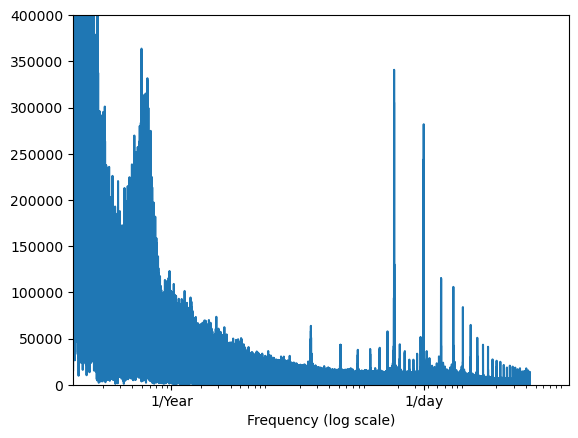

In [21]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

fft = tf.signal.rfft(londonData['energy(kWh/hh)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(londonData['energy(kWh/hh)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

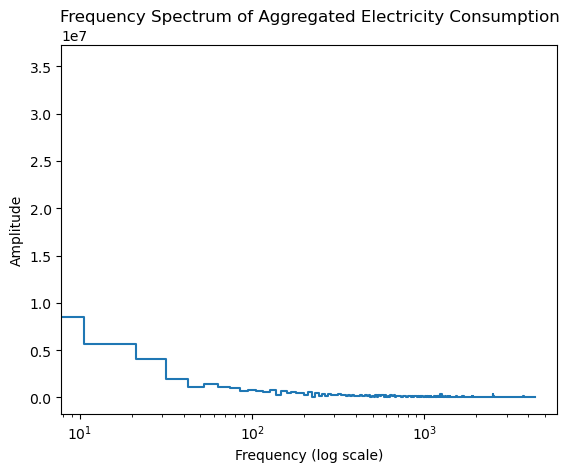

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Combine year, month, and day columns into a single datetime column
londonData['date'] = pd.to_datetime(londonData[['year', 'month', 'day']])

# Aggregate the consumption data across all customers for each day
aggregated_consumption = londonData.groupby('date')['energy(kWh/hh)'].sum().reset_index()
aggregated_consumption = aggregated_consumption.drop_duplicates('date')

# Perform Fourier transform
fft = tf.signal.rfft(aggregated_consumption['energy(kWh/hh)'])

# Calculate frequencies
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(aggregated_consumption)
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / hours_per_year
f_per_year = f_per_dataset / years_per_dataset

# Plot the frequency spectrum
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xlabel('Frequency (log scale)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Aggregated Electricity Consumption')
plt.show()

# ==== SAVE AND LOAD ====
I decided to save the data as a pkl here so that I could just run the cells below this point.

## Split into Train and Test data

In [1]:
############################################
# This takes about 35 seconds to a minute  #
############################################

import pandas as pd

# These libraries are supposed to accelerate some operations
import numexpr
import bottleneck
pd.set_option("compute.use_bottleneck", False)
pd.set_option("compute.use_numexpr", False)

# Load
import pandas as pd
path = "Data/pickles/"
londonData = pd.read_pickle(path + "londonData06CustomerInfo.pkl")
londonData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 167817020
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   energy(kWh/hh)   float64
 1   isNA             int32  
 2   year             int64  
 3   month            int64  
 4   day              int64  
 5   hour             int64  
 6   minute           int64  
 7   dayNumber        int64  
 8   weekend          int32  
 9   CustomerCount    float64
 10  dipDay           int32  
 11  ToU              int32  
 12  AG__ACORN-       uint8  
 13  AG__ACORN-U      uint8  
 14  AG__Adversity    uint8  
 15  AG__Affluent     uint8  
 16  AG__Comfortable  uint8  
dtypes: float64(2), int32(4), int64(6), uint8(5)
memory usage: 14.5 GB


In [2]:
londonData.head()

,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,weekend,CustomerCount,dipDay,ToU,AG__ACORN-,AG__ACORN-U,AG__Adversity,AG__Affluent,AG__Comfortable
0,0.0,0,2012,10,12,0,30,4,0,5261.0,0,0,0,0,0,1,0
1,0.0,0,2012,10,12,1,0,4,0,5261.0,0,0,0,0,0,1,0
2,0.0,0,2012,10,12,1,30,4,0,5261.0,0,0,0,0,0,1,0
3,0.0,0,2012,10,12,2,0,4,0,5261.0,0,0,0,0,0,1,0
4,0.0,0,2012,10,12,2,30,4,0,5261.0,0,0,0,0,0,1,0


In [3]:
column_indices = {name: i for i, name in enumerate(londonData.columns)}

n = len(londonData)
train_df = londonData[0:int(n*0.7)]
val_df = londonData[int(n*0.7):int(n*0.9)]
test_df = londonData[int(n*0.9):]

num_features = londonData.shape[1]

In [4]:
train_df.describe().astype(int)

,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,weekend,CustomerCount,dipDay,ToU,AG__ACORN-,AG__ACORN-U,AG__Adversity,AG__Affluent,AG__Comfortable
count,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914,117471914
mean,0,0,2012,6,15,11,14,2,0,4977,0,0,0,0,0,0,0
std,0,0,0,3,8,6,14,1,0,916,0,0,0,0,0,0,0
min,0,0,2011,1,1,0,0,0,0,0,0,0,0,0,0,0,0
25%,0,0,2012,4,8,6,0,1,0,5032,0,0,0,0,0,0,0
50%,0,0,2013,7,16,12,16,3,0,5250,0,0,0,0,0,1,0
75%,0,0,2013,10,23,18,30,5,1,5407,0,0,0,0,0,1,1
max,10,1,2014,12,31,23,37,6,1,5535,1,1,1,1,1,1,1


In [5]:
val_df.describe().astype(int)

,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,weekend,CustomerCount,dipDay,ToU,AG__ACORN-,AG__ACORN-U,AG__Adversity,AG__Affluent,AG__Comfortable
count,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404,33563404
mean,0,0,2012,6,15,11,15,2,0,5051,0,0,0,0,0,0,0
std,0,0,0,3,8,6,14,1,0,794,0,0,0,0,0,0,0
min,0,0,2011,1,1,0,0,0,0,0,0,0,0,0,0,0,0
25%,0,0,2012,4,8,6,0,1,0,5075,0,0,0,0,0,0,0
50%,0,0,2013,7,16,12,18,3,0,5262,0,0,0,0,1,0,0
75%,0,0,2013,10,23,18,30,5,1,5416,0,0,0,0,1,0,0
max,9,1,2014,12,31,23,37,6,1,5535,1,1,0,0,1,1,1


In [6]:
test_df.describe().astype(int)

,energy(kWh/hh),isNA,year,month,day,hour,minute,dayNumber,weekend,CustomerCount,dipDay,ToU,AG__ACORN-,AG__ACORN-U,AG__Adversity,AG__Affluent,AG__Comfortable
count,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703,16781703
mean,0,0,2012,6,15,11,14,2,0,4974,0,0,0,0,0,0,0
std,0,0,0,3,8,6,14,1,0,884,0,0,0,0,0,0,0
min,0,0,2011,1,1,0,0,0,0,0,0,0,0,0,0,0,0
25%,0,0,2012,4,8,6,0,1,0,5008,0,0,0,0,1,0,0
50%,0,0,2013,7,16,12,16,3,0,5244,0,0,0,0,1,0,0
75%,0,0,2013,10,23,18,30,5,1,5405,0,0,0,0,1,0,0
max,5,1,2014,12,31,23,54,6,1,5535,1,1,0,0,1,1,0


In [8]:
# Save
path = "Data/pickles/"
train_df.to_pickle(path + "data_training.pkl")
val_df.to_pickle(path + "data_validation.pkl")
test_df.to_pickle(path + "data_test.pkl")


In [9]:
import pickle 

with open('indeces.pkl', 'wb') as f:
    pickle.dump(column_indices, f)
        
